# PROBLEM
#### DATA COLLECTION
#### DATA PREPROCESSING
#### FEATURE ENGINEERING?
#### TRAINING SPLIT
#### TREATING THE MODEL
#### TRAINING THE MODEL
#### HYPERPARAMETER TUNING
#### TEST DATA EVALUATION

Imports

In [369]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

In [370]:
df = pd.read_csv("realtor-data.csv")
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [371]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904966 entries, 0 to 904965
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          904966 non-null  object 
 1   bed             775126 non-null  float64
 2   bath            791082 non-null  float64
 3   acre_lot        638324 non-null  float64
 4   city            904894 non-null  object 
 5   state           904966 non-null  object 
 6   zip_code        904762 non-null  float64
 7   house_size      612080 non-null  float64
 8   prev_sold_date  445865 non-null  object 
 9   price           904895 non-null  float64
dtypes: float64(6), object(4)
memory usage: 69.0+ MB


Visualizing N/A values

In [372]:
df.isnull().sum().sort_values(ascending=False)

prev_sold_date    459101
house_size        292886
acre_lot          266642
bed               129840
bath              113884
zip_code             204
city                  72
price                 71
status                 0
state                  0
dtype: int64

In [373]:
# sns.heatmap(df.isnull(), yticklabels=False)

In [374]:
#Remove houses not ready for sale then we can remove this variable
df = df.drop(df[df['status'] != 'for_sale'].index)
df = df.drop('status', axis = 1)

#Remove houses with no price
df = df.dropna(subset='price')

#Remove unimportant prev_sold_date, city, and zip_code variables
df = df.drop(['prev_sold_date', 'city', 'zip_code'], axis=1)

#Remove rows with two or more NaN values
df = df.dropna(thresh = 2)

In [375]:
print("Raw numbers")
print(df.isnull().sum().sort_values(ascending=False))
print("\nPercentages")
print(((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False))       

Raw numbers
house_size    292886
acre_lot      265049
bed           129840
bath          112291
state              0
price              0
dtype: int64

Percentages
house_size    32.421381
acre_lot      29.339929
bed           14.372801
bath          12.430192
state          0.000000
price          0.000000
dtype: float64


In [376]:
#Because bed and bath NaN values contribute to less than 15% of the
#904966 entry dataset, we can drop these rows
df = df.dropna(subset = ['bed', 'bath'])

In [377]:
df["state"].value_counts() 

state
New Jersey        216004
New York          175189
Massachusetts     148332
Connecticut        78235
New Hampshire      32171
Rhode Island       28212
Vermont            28121
Maine              24564
Puerto Rico        21313
Pennsylvania       15044
Delaware            1988
Virgin Islands       742
Georgia               48
Wyoming                3
West Virginia          3
Name: count, dtype: int64

In [378]:
#Since Georgia, Wyoming, and West Virginia only contribute to 54 entries, we can drop these values
df = df[~df['state'].isin(["Georgia", "Wyoming", "West Virginia"])]
print(df['state'].unique())


['Puerto Rico' 'Virgin Islands' 'Massachusetts' 'Connecticut' 'New Jersey'
 'New York' 'New Hampshire' 'Vermont' 'Rhode Island' 'Maine'
 'Pennsylvania' 'Delaware']


In [379]:
state_names = df['state'].unique()
state_mapping = {state: i for i, state in enumerate(state_names)}
df['state #'] = df['state'].map(state_mapping)

for state, number in state_mapping.items():
    print(f"{state}: {number}")
    
df = df.drop('state', axis = 1)
# numeric_value_for_desired_state = state_mapping[desired_state]

Puerto Rico: 0
Virgin Islands: 1
Massachusetts: 2
Connecticut: 3
New Jersey: 4
New York: 5
New Hampshire: 6
Vermont: 7
Rhode Island: 8
Maine: 9
Pennsylvania: 10
Delaware: 11


In [380]:
#plt.plot(df['price'], 'o')
#plt.title("Plot of prices")
#plt.ylabel("Value")
#plt.show()

In [381]:
#df = df.drop(df[df['price'] > 6000000].index)
#plt.plot(df['price'], 'o')
#plt.title("Plot of prices")
#plt.ylabel("Value")
#plt.show()


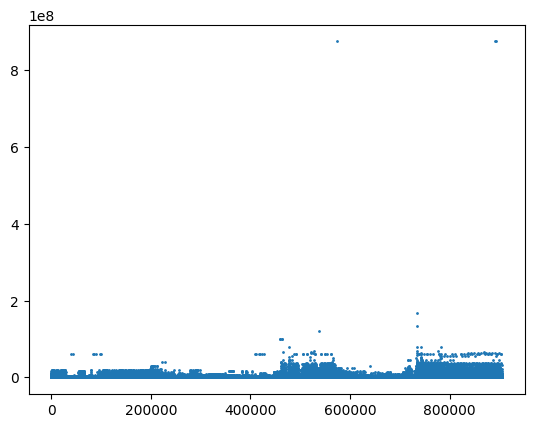

In [382]:
#df = df.drop(df[df['price'] > 800000000].index)
plt.scatter(df.index, df['price'].values, s = 1)
plt.show()